In [1]:

import os
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [2]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok= True)

In [3]:
cora_dataset = Planetoid(root=data_dir, name='Cora', transform=NormalizeFeatures())

In [4]:
data = cora_dataset[0]

In [5]:
print(f'Number of graphs: {len(cora_dataset)}')

Number of graphs: 1


In [6]:
print("Number of features:", cora_dataset.num_classes)

Number of features: 7


In [7]:
print("Number of features:", cora_dataset.num_features)

Number of features: 1433


In [8]:
data.x[0][:50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [9]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [10]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv

In [11]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

In [12]:

class GFusion(torch.nn.Module):
	def __init__(self, num_features, num_classes):
		super(GFusion, self).__init__()
		self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.4)
		self.cconv1 = GCNConv(8*8,8*8, cached=True, normalize=True)
		self.conv2 = GATConv(8*8, 8*8, heads=1, concat=True, dropout=0.4)
		self.cconv2 = GCNConv(8*8, num_classes, cached=True, normalize=True)

	def forward(self, x, edge_index):
		x = self.conv1(x, edge_index)
		x = F.elu(x)
		x = self.cconv1(x, edge_index)
		x = F.relu(x)
		x = self.conv2(x, edge_index)
		x = F.elu(x)
		x = self.cconv2(x, edge_index)
		return F.log_softmax(x, dim=1)

In [13]:

# The GATConv class implements the Graph Attention Network layer introduced in the GAT paper.

class GAT(torch.nn.Module):
	def __init__(self, num_features, num_classes):
		super(GAT, self).__init__()
		self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
		self.conv2 = GATConv(8*8, num_classes, heads=1, concat=True, dropout=0.6)

	def forward(self, x, edge_index):
		x = self.conv1(x, edge_index)
		x = F.elu(x)
		x = self.conv2(x, edge_index)
		return F.log_softmax(x, dim=1)

In [14]:
# The GCN Model

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(cora_dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, cora_dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = GCN(hidden_channels=16)
model = GFusion(num_features=cora_dataset.num_features, num_classes=cora_dataset.num_classes)
print(model)
model = model.to(device)
data = data.to(device)

GFusion(
  (conv1): GATConv(1433, 8, heads=8)
  (cconv1): GCNConv(64, 64)
  (conv2): GATConv(64, 64, heads=1)
  (cconv2): GCNConv(64, 7)
)


In [16]:
# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters()
                             ,lr = learning_rate,
                             weight_decay= decay)

In [17]:
# Loss Function
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss



In [19]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc

In [20]:
losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch:{epoch:03d}, Loss:{loss:.4f}')

Epoch:000, Loss:1.9461
Epoch:100, Loss:0.0801
Epoch:200, Loss:0.0172
Epoch:300, Loss:0.0174
Epoch:400, Loss:0.0171
Epoch:500, Loss:0.0327
Epoch:600, Loss:0.0323
Epoch:700, Loss:0.0308
Epoch:800, Loss:0.0190
Epoch:900, Loss:0.0278
Epoch:1000, Loss:0.0274


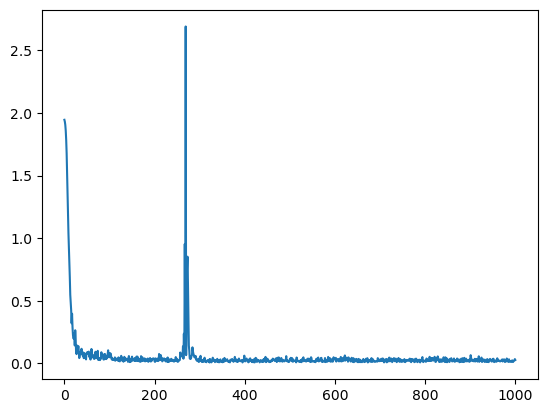

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = plt.plot(loss_indices, losses_float)


In [22]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7730
